In [1]:
from copy import deepcopy 

import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

from SmithZero import D2torchEngine

In [2]:
torch.manual_seed(42)

### Data Preparation 

In [3]:
from torchvision.datasets import CIFAR10 
import torchvision.transforms as T


# === data transformation === # 
train_T = T.Compose([   T.RandomCrop(32, padding=4),
                        T.RandomHorizontalFlip(), 
                        T.ToTensor(), 
                        T.Normalize(mean= (0.4914, 0.4822, 0.4465),
                                    std=(0.2023, 0.1994, 0.2010)),
                    ])

test_T = T.Compose([T.ToTensor(),
                    T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                std=(0.2023, 0.1994, 0.2010))
                    ])                  


# === download dataset object === # 
train_data = CIFAR10 (  root="./dataset/train",
                        train=True,
                        download=True,
                        transform=train_T )

test_data = CIFAR10 (   root="./dataset/test",
                        train=False,
                        download=True, 
                        transform=test_T )  

Files already downloaded and verified
Files already downloaded and verified


### Data Batching 

In [4]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_data,
                        batch_size=124,
                        shuffle=True, 
                        num_workers=4 
                        )

testloader = DataLoader(test_data,
                        batch_size=124,
                        num_workers=4
                        )

### Model Design 

In [5]:
class LeNet(nn.Module):
    def __init__(self, in_channels=3, n_class=10, p=0.5):
        super(LeNet, self).__init__()
        self.p = p # probability for DropOut layer 
        
        # === Create the convolution layers === # 
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, padding=2)
        self.c3 = nn.Conv2d(6, 16, 5) 
        self.c5 = nn.Conv2d(16, 120, 5) 

        # === Create the linear layers === # 
        self.f6 = nn.Linear(in_features=480, out_features=84)
        self.output = nn.Linear(in_features=84, out_features=n_class)

        # === Create dropout layers === # 
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # === block1 === # 
        x = self.c1(x)
        x = F.relu(x) 
        x = F.max_pool2d(x, kernel_size=2)
        # === block2 === # 
        x = self.c3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # === block3 === # 
        x = self.c5(x)
        x = F.relu(x)
        # ==== flattening === #
        x = nn.Flatten()(x)
        return x 

    def classifier(self, x): 
        # === hidden layler === # 
        if self.p > 0: 
            x = self.drop(x)        
        x = self.f6(x)
        x = F.relu(x)

        # === output layer === # 
        if self.p > 0 :
            x = self.drop(x)
        x = self.output(x)
        return x 
    
    def forward(self, x):
        x = self.featurizer(x) # return (1, 480)
        x = self.classifier(x) # return (1, 10)
        return x 

***

In [6]:
def set_optimizer(self, optimizer): 
    self.optimizer = optimizer

# add attribute 
setattr(D2torchEngine, 'set_optimizer', set_optimizer)

In [7]:
# add member variable 
setattr(D2torchEngine, 'scheduler', None)
setattr(D2torchEngine, 'is_batch_lr_scheduler', False)


def set_lr_scheduler(self, scheduler): 
    
    if scheduler.optimizer == self.optimizer:
        self.scheduler = scheduler 
        if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or 
            isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or 
            isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts)): 
            self.is_batch_lr_scheduler = True 
        else: 
            self.is_batch_lr_scheduler = False

setattr(D2torchEngine, 'set_lr_scheduler', set_lr_scheduler)

In [8]:
# add member variable 
setattr(D2torchEngine, 'learning_rates', [])

def _epoch_schedulers(self, val_loss):
    if self.scheduler:
        if not self.is_batch_lr_scheduler: # no schduler 
            if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(val_loss) 
            else: 
                self.scheduler.step()
            
            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups'])) 
            self.learning_rates.append(current_lr) # log of learninig_rates 

setattr(D2torchEngine, '_epoch_schedulers', _epoch_schedulers)

In [9]:
def train(self, n_epochs, seed=42):
    self.set_seed(seed) # To ensure reproducibility of the training process

    if self.wandb:
        # Tell wandb to watch what the model gets up to: gradients, weights, and more!
        self.wandb.watch(self.model, self.loss_fn, log="all", log_freq=10)
        self.wandb.define_metric("train_loss", summary="min") # (ref) https://docs.wandb.ai/guides/track/log
        self.wandb.define_metric("val_loss", summary="min")    

    for epoch in tqdm(range(n_epochs)):
        self.total_epochs += 1

        # === TRAINING === # 
        train_loss = self._mini_batch(validation=False) 
        self.train_losses.append(train_loss)

        # === VALIDATION === # 
        # Set no gradients ! 
        with torch.no_grad(): 
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        self._epoch_schedulers(val_loss) # learning_rate scheduler

        # === If a W&B has been set === # 
        if self.wandb: 
            # Record logs of both losses for each epoch 
            log_dict = {"epoch":epoch, "train_loss":train_loss}

            if val_loss is not None:
                update_dict = {'val_loss': val_loss} 
                log_dict.update(update_dict)  # dict() update 

            if self.scheduler is not None: 
                log_dict.update({'lr_schedule': np.array(self.learning_rates[-1][-1])}) # get the last LR
            
            self.wandb.log(log_dict)

setattr(D2torchEngine, 'train', train)

In [10]:
def _mini_batch_schedulers(self, frac_epoch): 
    if self.scheduler: 
        if self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts): 
                self.scheduler.step(self.total_epochs + frac_epoch)
            else: 
                self.scheduler.step()

            current_lr = list(map(lambda d:d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr) # log of learninig_rates 

setattr(D2torchEngine, '_mini_batch_schedulers', _mini_batch_schedulers)

In [11]:
def _mini_batch(self, validation=False): 
    if validation : 
        data_loader = self.val_loader
        step = self.val_step
    else: 
        data_loader = self.train_loader 
        step = self.train_step 
    
    if data_loader is None: 
        print(f"No any dataloader @ validation={validation}")
        return None 
    
    n_batches = len(data_loader)

    # === Run loop === # 
    mini_batch_losses = [] 
    for i, (x_batch, y_batch) in enumerate(data_loader): 
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)
    
        mini_batch_loss = step(x_batch, y_batch) # train/val-step
        mini_batch_losses.append(mini_batch_loss)

        if not validation: # only during training! 
            self._mini_batch_schedulers(i/n_batches)# call the learning rate scheduler 
                                                    # at the end of every mini-batch update 
    
    # Return the avg. loss 
    return np.mean(mini_batch_losses)     

setattr(D2torchEngine, '_mini_batch', _mini_batch)

***

In [12]:
# === hyperparameter dict === # 
# you can receive with .yaml or .json 

hyperparams = dict(
        seed=42, 
        epochs=50,
        classes=10,
        batch_size=128,
        n_workers=4,
        learning_rate=1e-3,
        dropout_p = 0.5,
        dataset="CIFAR10",
        architecture="LeNet")

In [13]:
import wandb 

wandb.login() 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: doranlyong (use `wandb login --relogin` to force relogin)


True

In [14]:
proj_name = "LeNet-cifar10"

wandb.init(project=proj_name, config=hyperparams)
config = wandb.config 

/home/milky/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


### Model Configuration 

In [15]:
model = LeNet(in_channels=3, n_class=config.classes, p=config.dropout_p)

loss_fn = nn.CrossEntropyLoss(reduction='mean') 
optimizer = optim.Adam( model.parameters(), # (!) be sure to pass in the model.parameters() 
                        lr=config.learning_rate, 
                    ) 

* ```lr_range_test``` 메소드에 ```LRFnder``` 를 추가해서 수정하기 

/home/milky/anaconda3/envs/py38/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
100%|██████████| 100/100 [00:01<00:00, 89.16it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-03


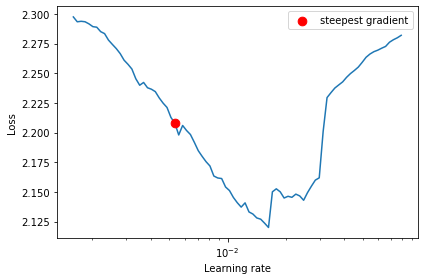

In [16]:
from torch_lr_finder import LRFinder

# === Learning Rate Range Test === #
# Using LRFinder instead of above method 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(trainloader, end_lr=1e-1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()

After getting the suggested learning rate, we can use it as the ```upper range``` of a ```cyclical scheduler```. <br/>
So, we re-create the optimizer

In [17]:
AgentDL = D2torchEngine(model, loss_fn, optimizer)


# === reset the optimzier === # 
reset_optimizer = optim.Adam(  model.parameters(), lr=5.34e-3 ) 
AgentDL.set_optimizer(reset_optimizer) 

### Set a scheduler 

In [18]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

scheduler = CosineAnnealingWarmRestarts(reset_optimizer, T_0=20, T_mult=4, eta_min=1e-5, last_epoch= -1, verbose=False)

AgentDL.set_lr_scheduler(scheduler)

In [19]:
AgentDL.optimizer == AgentDL.scheduler.optimizer

True

In [20]:
AgentDL.scheduler.optimizer.state_dict()['param_groups']

[{'lr': 0.00534,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'initial_lr': 0.00534,
  'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]

### Model Training 

In [21]:
AgentDL.set_loaders(trainloader, testloader)
AgentDL.set_wandb(wandb)

In [22]:
AgentDL.train(n_epochs=100, seed=config.seed)

100%|██████████| 100/100 [08:11<00:00,  4.92s/it]


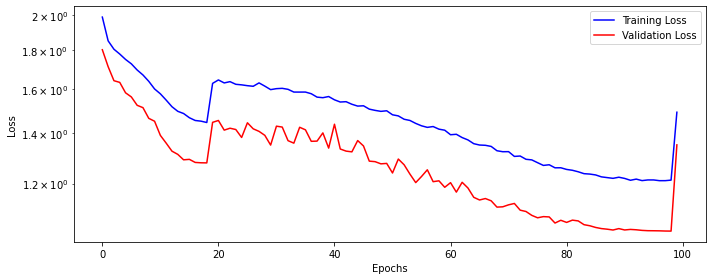

In [23]:
fig = AgentDL.plot_losses()

### Metrics 

In [24]:
results = AgentDL.loader_apply(AgentDL.train_loader, AgentDL.correct, reduce='sum') 

for idx, (n_correct, n_items) in enumerate(results):
    print(f"cls_idx_{idx}: {n_correct}/{n_items}") 


results = results.sum(axis=0) 
print(results)
print(f"Accuracy: {results[0]/results[1]:.3f}")

cls_idx_0: 2637/5000
cls_idx_1: 3814/5000
cls_idx_2: 1732/5000
cls_idx_3: 1733/5000
cls_idx_4: 2960/5000
cls_idx_5: 1465/5000
cls_idx_6: 1817/5000
cls_idx_7: 3100/5000
cls_idx_8: 3208/5000
cls_idx_9: 2802/5000
tensor([25268, 50000])
Accuracy: 0.505


In [25]:
results = AgentDL.loader_apply(AgentDL.val_loader, AgentDL.correct, reduce='sum') 

for idx, (n_correct, n_items) in enumerate(results):
    print(f"cls_idx_{idx}: {n_correct}/{n_items}") 


results = results.sum(axis=0) 
print(results)
print(f"Accuracy: {results[0]/results[1]:.3f}")

cls_idx_0: 567/1000
cls_idx_1: 814/1000
cls_idx_2: 372/1000
cls_idx_3: 303/1000
cls_idx_4: 581/1000
cls_idx_5: 344/1000
cls_idx_6: 419/1000
cls_idx_7: 669/1000
cls_idx_8: 659/1000
cls_idx_9: 564/1000
tensor([ 5292, 10000])
Accuracy: 0.529
